In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [2]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [4]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


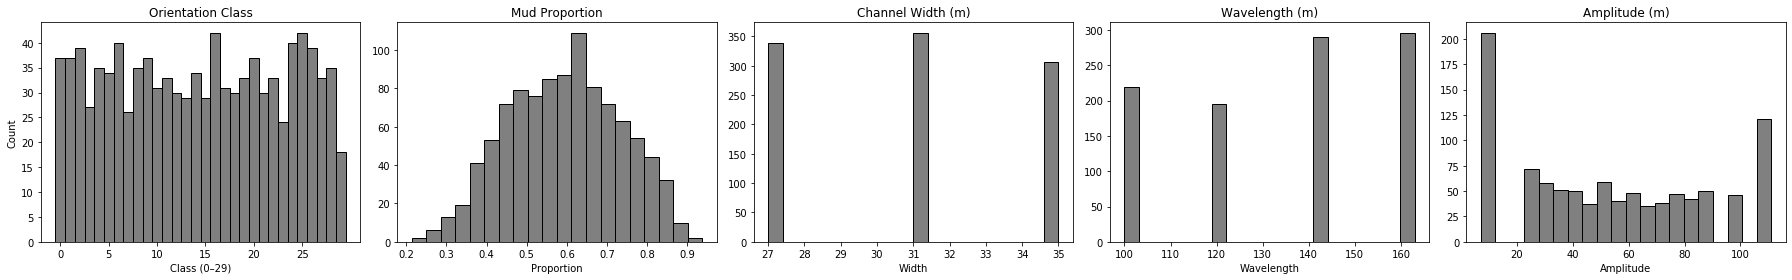

In [5]:
# Create 1-row, 5-column subplot layout
fig, ax = plt.subplots(1, 5, figsize=(25, 4))
plt.subplots_adjust(wspace=0.4)

# Plot orientation class histogram
ax[0].hist(orit_class, bins=np.arange(31)-0.5, color='gray', edgecolor='black')
ax[0].set_title('Orientation Class')
ax[0].set_xlabel('Class (0–29)')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, 30, 5))

# Plot mud proportion histogram
ax[1].hist(mudprop, bins=20, color='gray', edgecolor='black')
ax[1].set_title('Mud Proportion')
ax[1].set_xlabel('Proportion')

# Plot width histogram
ax[2].hist(width, bins=20, color='gray', edgecolor='black')
ax[2].set_title('Channel Width (m)')
ax[2].set_xlabel('Width')

# Plot wavelength histogram
ax[3].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[3].set_title('Wavelength (m)')
ax[3].set_xlabel('Wavelength')

# Plot amplitude histogram
ax[4].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[4].set_title('Amplitude (m)')
ax[4].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()


### 2. Train and load trained conditional generator

In [6]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_cond_gf/'
GANSim_name = 'network-snapshot-014720.pkl' 

recognizer_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FeatureRecognizer/'
recognizer_name = 'network-snapshot-069520.pkl' 

generator_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_unc/'
generator_name = 'network-snapshot-025921.pkl' 

# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import Generator.
    with open(GANSim_dir+GANSim_name, 'rb') as file:
        _, _, Gs_Gansim = pickle.load(file)     
    
    # Import trained global feature recognizer
    with open(recognizer_dir + recognizer_name, 'rb') as file:
        _, R, _ = pickle.load(file)
        
    with open(generator_dir+generator_name, 'rb') as file:
        _, _, Gs_unc = pickle.load(file) 

print(Gs_Gansim.input_shapes)
print(Gs_Gansim.output_shapes)

print(R.input_shapes)
print(R.output_shapes)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 8, 4, 4], [None, 34, 64, 64], [None, 0, 64, 64], [None, 0, 64, 64]]
[[None, 3, 64, 64]]
[[None, 1, 64, 64], [None, 0, 64, 64]]
[[None, 1], [None], [None], [None, 34]]


### 3. Facies geomodel prediction based on trained generator and evaluation


**Assume the channel direction corresponds to class 22 (42 to 48 degrees) The channel width, amplitude, and wavelength are 31 m, 55 m, and 121 m, respectively. The mud proportion of the reservoir is 0.65. **

In [7]:
orit_class_cond = 22
width_cond = 31
amplt_cond = 55
wvl_cond = 121
mudprop_cond = 0.65

# normalize the global features into a range of [-1, 1] which is used in training; orientation class is converted into maps.
orit_class_one_hot_cond = np.zeros(30)
orit_class_one_hot_cond[orit_class_cond - 1] = 1
width_cond = ((width_cond - 27) / 8 - 0.5) * 2
amplt_cond = ((amplt_cond - 7) / 104 - 0.5) * 2
wvl_cond = ((wvl_cond - 100) / 63 - 0.5) * 2
mudprop_cond = ((mudprop_cond - 0.1677) / 0.8037 - 0.5) * 2

labels_cond = np.concatenate((orit_class_one_hot_cond, [mudprop_cond, width_cond, wvl_cond, amplt_cond]))[np.newaxis, :]
print(labels_cond.shape)

(1, 34)


In [8]:
import time

TotalModel_no_cond_sim = 200
latents_cond_sim = np.random.RandomState(412).randn(TotalModel_no_cond_sim, 8, 4, 4)
labels_cond_sim = np.tile(np.expand_dims(np.expand_dims(labels_cond, axis = -1), axis = -1), (TotalModel_no_cond_sim, 1, 64, 64))
print(labels_cond_sim.shape)

wellfacies_cond_sim = np.zeros([TotalModel_no_cond_sim, 0, 64, 64])
prob_cond_sim = np.zeros((TotalModel_no_cond_sim, 0, 64, 64))  #probimgs_test

# generation of facies indicator models from the trained generator
start_time = time.time()
fakemodel_indicators_cond_sim = Gs_Gansim.run(latents_cond_sim, labels_cond_sim, wellfacies_cond_sim, prob_cond_sim)
print(fakemodel_indicators_cond_sim.shape)

# facies models through argmax
fakemodels_cond_sim = np.expand_dims(np.argmax(fakemodel_indicators_cond_sim, axis = 1), axis = 1)
end_time = time.time()

print(fakemodels_cond_sim.shape)
# Output the execution time 
print("Execution Time: {:.4f} seconds".format((end_time - start_time) / TotalModel_no_cond_sim))


(200, 34, 64, 64)
(200, 3, 64, 64)
(200, 1, 64, 64)
Execution Time: 0.0159 seconds


In [9]:
# Calculate the global features for the generated facies models using the trained recognizer

labels_cond_R = R.run(fakemodels_cond_sim, wellfacies_cond_sim)[-1]
    
orit_one_hot_cond_R = labels_cond_R[:, :30]
orit_class_cond_R = np.argmax(orit_one_hot_cond_R, axis = 1)  #

mudprop_cond_R = labels_cond_R[:, 30] 
mudprop_cond_R = (mudprop_cond_R / 2 + 0.5) * 0.8037 + 0.1677

wid_cond_R = labels_cond_R[:, 31]  # width after normalization
wid_cond_R = np.where(wid_cond_R < -0.5, -1, np.where(wid_cond_R > 0.5, 1, 0)) 
wid_cond_R = (wid_cond_R / 2 + 0.5) * 8 + 27

wvl_cond_R = labels_cond_R[:, 32]  # width after normalization
wvl_cond_R = np.where(wvl_cond_R < -0.5, -1, np.where(wvl_cond_R < 0., -0.33, np.where(wvl_cond_R > 0.5, 1, 0.3))) 
wvl_cond_R = np.round((wvl_cond_R / 2 + 0.5) * 63 + 100)

amplt_cond_R = labels_cond_R[:, 33] 
amplt_cond_R = (amplt_cond_R / 2 + 0.5) * 104 + 7 

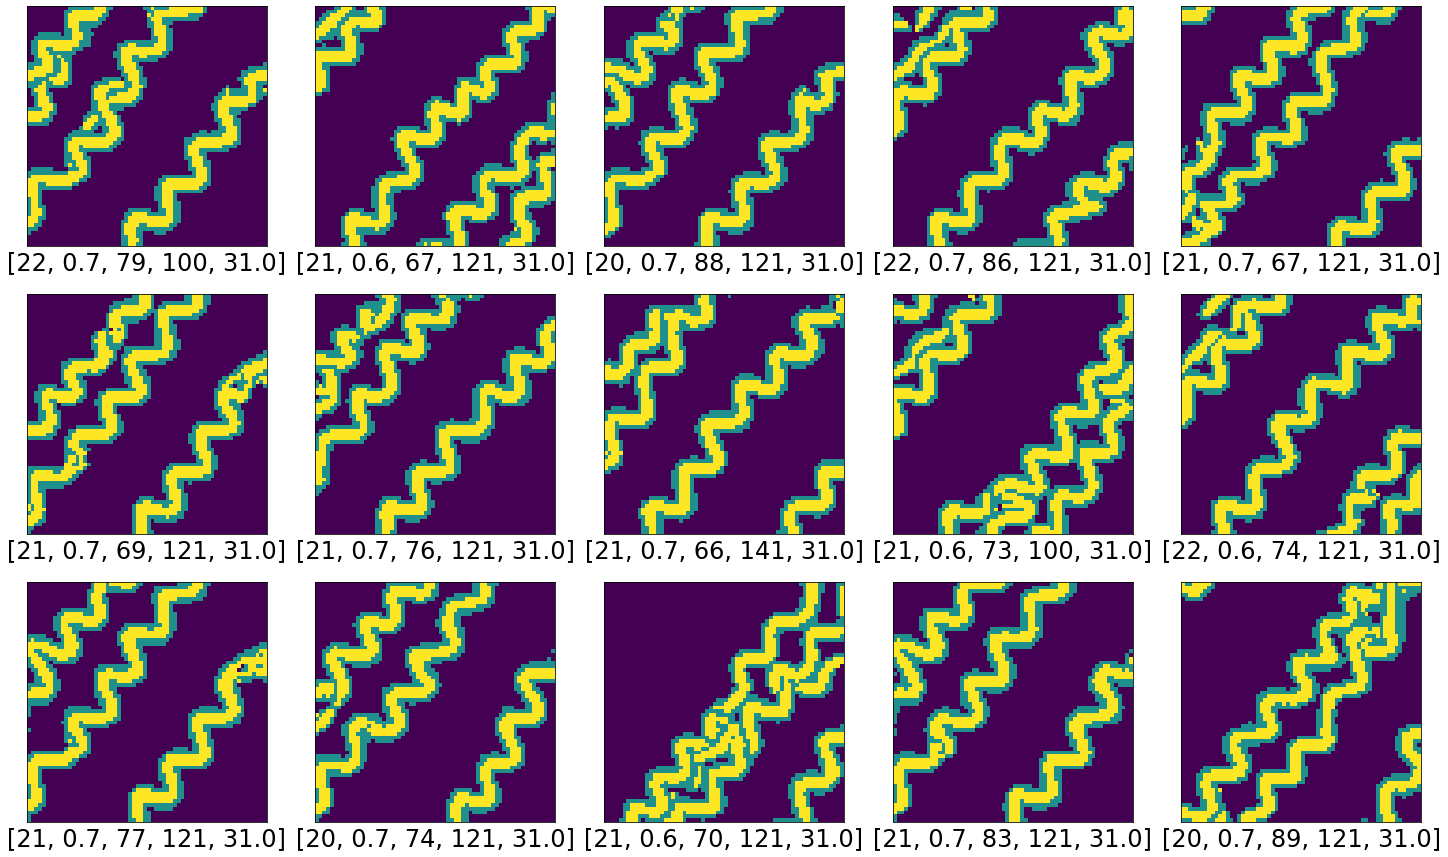

In [10]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(fakemodels_cond_sim[j, 0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{orit_class_cond_R[j]:.0f}, {mudprop_cond_R[j]:.1f}, {amplt_cond_R[j]:.0f}, {wvl_cond_R[j]:.0f}, {wid_cond_R[j]:.1f}]') 
    ax[0, j].set_yticks([])

for j in range(5):
    idx = j + 15
    ax[1, j].imshow(fakemodels_cond_sim[idx, 0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{orit_class_cond_R[idx]:.0f}, {mudprop_cond_R[idx]:.1f}, {amplt_cond_R[idx]:.0f}, {wvl_cond_R[idx]:.0f}, {wid_cond_R[idx]:.1f}]') 
    ax[1, j].set_yticks([])

for j in range(5):
    idx = j + 25
    ax[2, j].imshow(fakemodels_cond_sim[idx, 0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{orit_class_cond_R[idx]:.0f}, {mudprop_cond_R[idx]:.1f}, {amplt_cond_R[idx]:.0f}, {wvl_cond_R[idx]:.0f}, {wid_cond_R[idx]:.1f}]') 
    ax[2, j].set_xticks([])
    ax[2, j].set_yticks([])

# plt.savefig(GANSim_dir + "_13440_cond_random_15FaciesMaps_1.jpg", dpi=200)
  

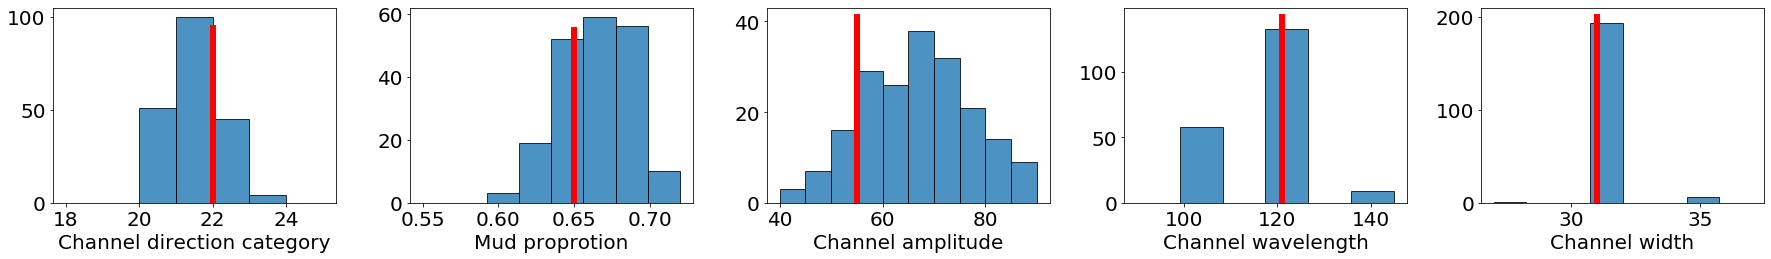

In [11]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 4)

# Plot the histogram with probability density
ax[0].hist(orit_class_cond_R, bins=7, range = (18, 25), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[0].plot([22, 22], [0, 94], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[0].set_xlabel(f'Channel direction category')

# Plot the histogram with probability density
ax[1].hist(mudprop_cond_R, bins=8, range = (0.55, 0.72), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[1].plot([0.65, 0.65], [0, 55], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[1].set_xlabel(f'Mud proprotion')

ax[2].hist(amplt_cond_R, bins=10, range = (40, 90), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[2].plot([55, 55], [0, 41], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[2].set_xlabel(f'Channel amplitude')

ax[3].hist(wvl_cond_R, bins=6, range = (90, 145), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[3].plot([121, 121], [0, 142], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[3].set_xlabel(f'Channel wavelength')

ax[4].hist(wid_cond_R, bins=8, range = (27, 37), alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[4].plot([31, 31], [0, 200], 'r-', linewidth=6)  # Increase linewidth for a bolder appearance
ax[4].set_xlabel(f'Channel width')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)  # Increase this value for more space

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

#plt.savefig(GANSim_dir + "_13440_cond_Geometrical histograms.jpg", dpi=80)  

### 4. Comparison of predicted facies models from post-GANs, GANSim, and MPS

*Load MPS results of direct sampling method*

In [12]:
import os

ds_uncond_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MPS_unc/DS_unc/'

n = 15
t = 0.1
t = f"{t:.3f}"
f = 1.00
f = f"{f:.2f}"
ds_folder_name = 'n_' + str(n) + '_t_' + str(t) + '_f_' + str(f)
ds_file_path = os.path.join(ds_uncond_dir, ds_folder_name, 'all_sim_results.npy')
ds_mps_results = np.load(ds_file_path)
ds_mud_prop = np.mean(np.where(ds_mps_results == 0, 1, 0), axis = (1, 2))


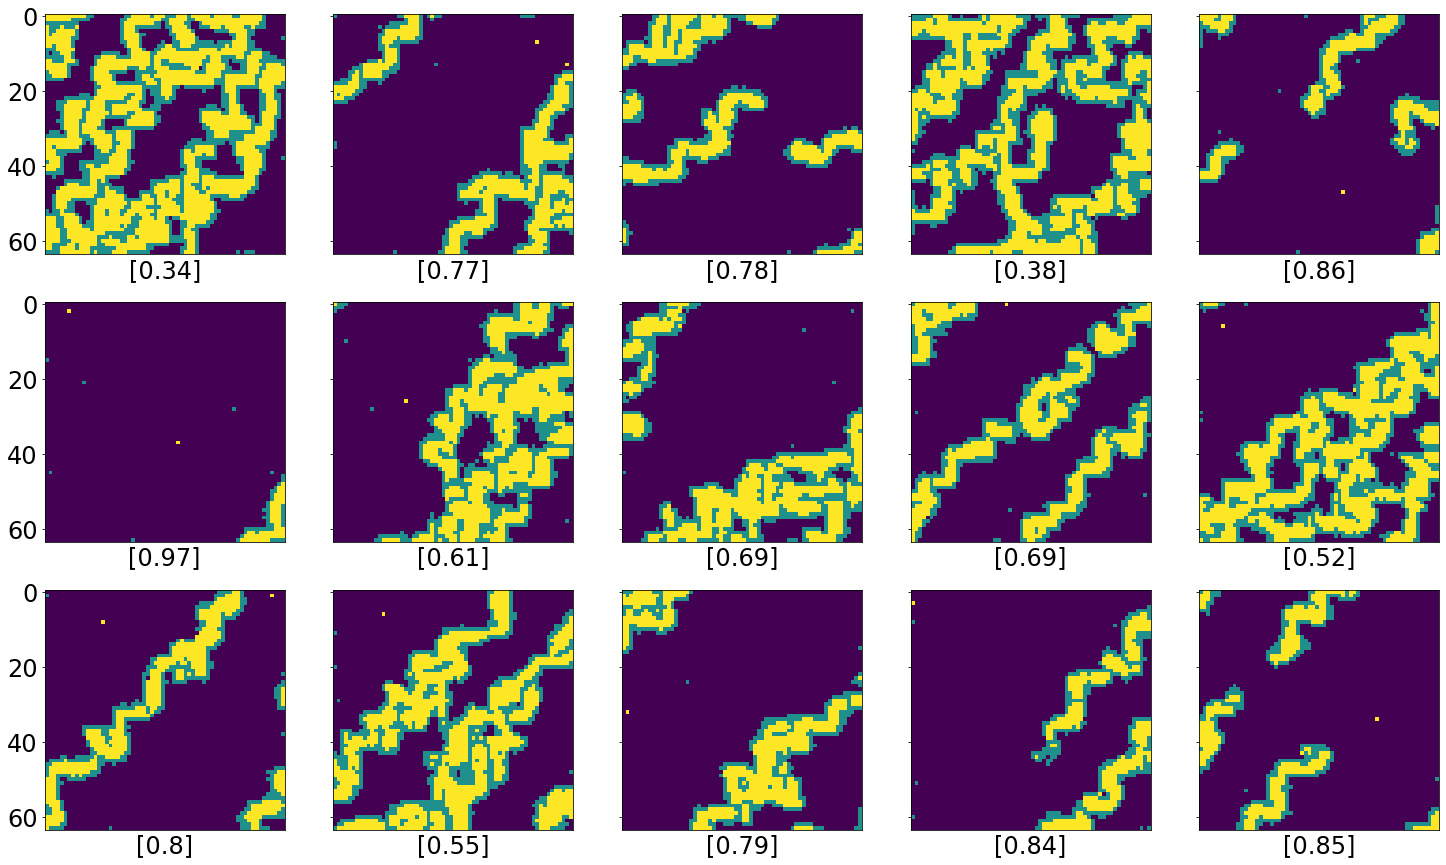

In [13]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(ds_mps_results[j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(ds_mud_prop[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(ds_mps_results[j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(ds_mud_prop[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(ds_mps_results[j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(ds_mud_prop[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load MPS results of quick sampling method*

In [15]:
qs_uncond_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MPS_unc/QS_unc/'

n = 15
k = 1
qs_folder_name = 'n_' + str(n) + '_k_' + str(k)
qs_file_path = os.path.join(qs_uncond_dir, qs_folder_name, 'all_sim_results.npy')
qs_mps_results = np.load(qs_file_path)
qs_mud_prop = np.mean(np.where(qs_mps_results == 0, 1, 0), axis = (1, 2))


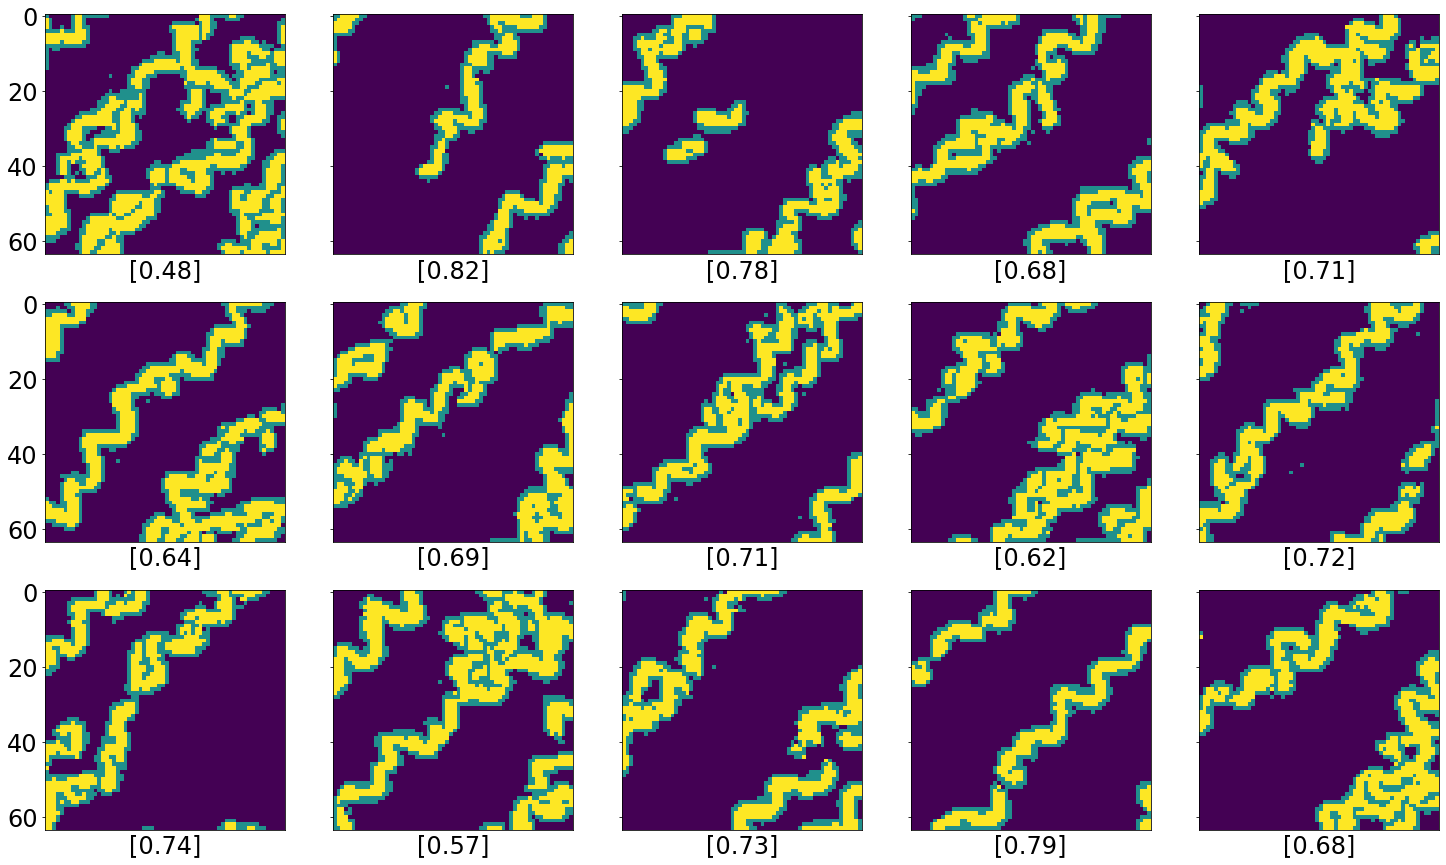

In [16]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(qs_mps_results[j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(qs_mud_prop[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(qs_mps_results[j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(qs_mud_prop[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(qs_mps_results[j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(qs_mud_prop[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load MPS results of SNESim method*

In [17]:
snesim_Filepath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MPS_unc/SNESIM_unc/SNeSim_Petrel_AllPatternSizes'

allele=[]  # store all elements of the file. including 64*64 lists, and each list includes code for all realizations
with open (snesim_Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:            
            allele.append(eles)
        
partimgs=np.array(allele, dtype=np.float32)[:, 3:].reshape(64, 64, -1).astype(np.int32)  # all imges (realizations), of shape (64,64, rlz_no)
partimgs = np.where(partimgs == 1, 4, partimgs)/2 # exchange code of levee and channels
partimgs = partimgs[::-1,:,:]
snesim_mps_results = partimgs[:, :, 3 * 99: 4 * 99 + 1]
print(snesim_mps_results.shape)

snesim_mud_prop = np.mean(np.where(snesim_mps_results == 0, 1, 0), axis = (0, 1))


(64, 64, 100)


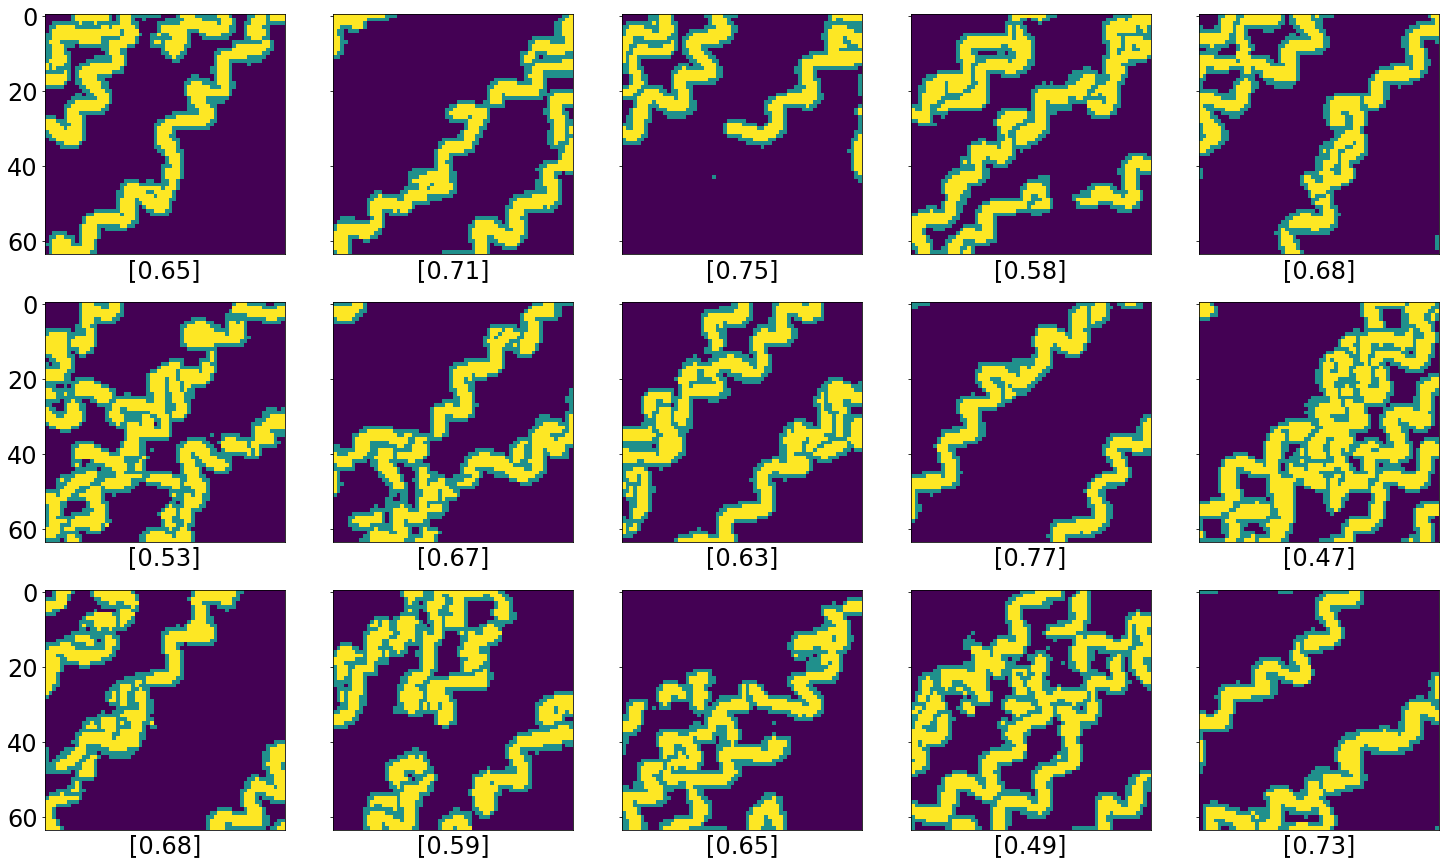

In [18]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(snesim_mps_results[:, :, j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(snesim_mud_prop[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(snesim_mps_results[:, :, j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(snesim_mud_prop[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(snesim_mps_results[:, :, j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(snesim_mud_prop[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load post-GANs (MCMC) results*

In [19]:
mcmc_dir = "/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MCMCForGlobalFeatureConditioning/"
mcmc_convg_info_fname =  mcmc_dir + "MCMC_Fluvial_10chainx50kiter_sig_p1.txt"

allele=[] 
with open(mcmc_convg_info_fname, 'r') as f:
    for line in f:
        eles = line.strip().split(' ')
        allele.append(eles)

converg_info = np.array(allele, dtype = float).reshape((-1, 131))
print(converg_info.shape)

converg_chains = converg_info[:, 0]
converg_times = converg_info[:, 1]
converg_dists = converg_info[:, 2]
converg_latents = converg_info[:,3:].reshape(-1, 8, 4, 4)

all_chain_dist_ord = np.argwhere(converg_dists<0.2)[:, 0]
converg_dists_all_chains = converg_dists[all_chain_dist_ord]
converg_latents_all_chains = converg_latents[all_chain_dist_ord]

sample_numb = 200
random_index = np.random.RandomState(66).permutation(converg_latents_all_chains.shape[0])[:sample_numb]
sampled_latents_MCMC = converg_latents_all_chains[random_index]
sampled_dists_MCMC = converg_dists_all_chains[random_index]
   
labels_run = np.zeros((sample_numb, 0, 4, 4))
wellfacies_run = np.zeros((sample_numb, 0, 64, 64)) 
prob_run = np.zeros((sample_numb, 0, 64, 64)) 
fakemodel_indicators = Gs_unc.run(sampled_latents_MCMC, labels_run, wellfacies_run, prob_run)
fakemodel_mcmc = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)  # [N, 1, 64, 64]
    
labels_mcmc_R = R.run(fakemodel_mcmc, wellfacies_run)[-1]   
orit_one_hot_mcmc_R = labels_mcmc_R[:, :30]
orit_class_mcmc_R = np.argmax(orit_one_hot_mcmc_R, axis = 1)  #
mudprop_mcmc_R = labels_mcmc_R[:, 30] 
mudprop_mcmc_R = (mudprop_mcmc_R / 2 + 0.5) * 0.8037 + 0.1677
wid_mcmc_R = labels_mcmc_R[:, 31]  # width after normalization
wid_mcmc_R = np.where(wid_mcmc_R < -0.5, -1, np.where(wid_mcmc_R > 0.5, 1, 0)) 
wid_mcmc_R = (wid_mcmc_R / 2 + 0.5) * 8 + 27
wvl_mcmc_R = labels_mcmc_R[:, 32]  # width after normalization
wvl_mcmc_R = np.where(wvl_mcmc_R < -0.5, -1, np.where(wvl_mcmc_R < 0., -0.33, np.where(wvl_mcmc_R > 0.5, 1, 0.3))) 
wvl_mcmc_R = np.round((wvl_mcmc_R / 2 + 0.5) * 63 + 100)
amplt_mcmc_R = labels_mcmc_R[:, 33] 
amplt_mcmc_R = (amplt_mcmc_R / 2 + 0.5) * 104 + 7


(61803, 131)


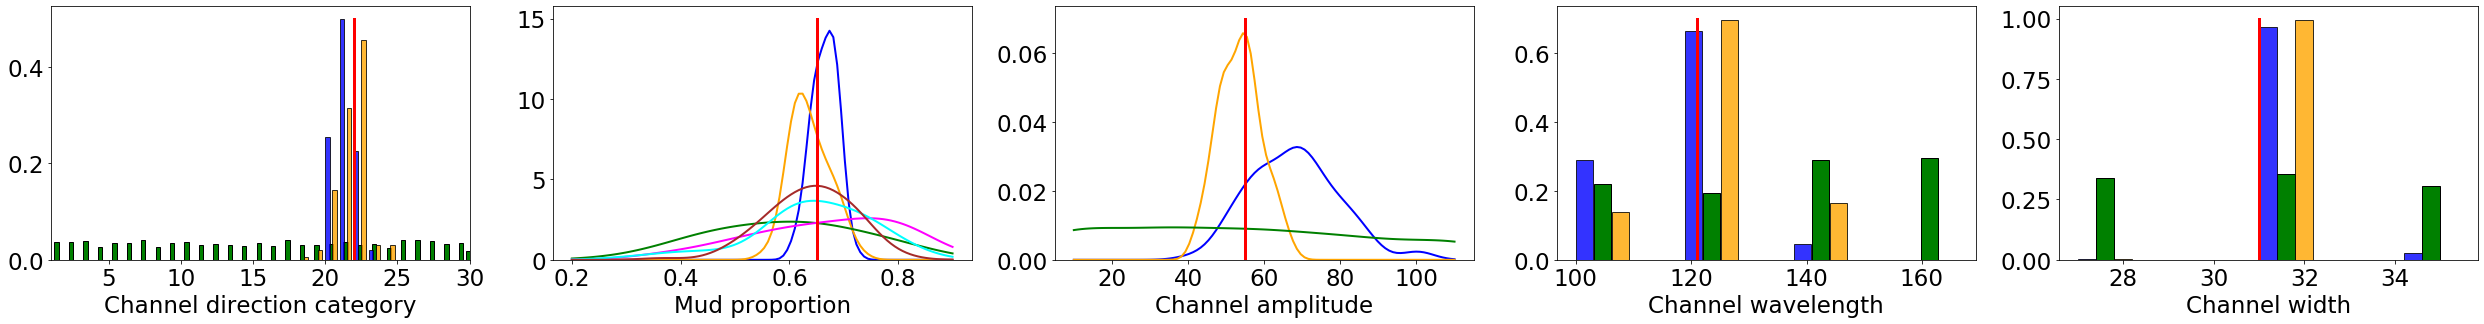

In [20]:
plt.rcParams.update({'font.size': 23})

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(35, 5)

# Plot the histograms for orit_class_cond_R, orit_class_mcmc_R, and orit_class
barwidth = 0.3  # Width for each bar
bin_edges = np.arange(1, 30.5, 0.5)
#ax[0].hist(orit_class_cond_R, bins=bin_edges, alpha=0.5, histtype='bar', ec='black', color='blue', label='cond', density=True, width=barwidth, align='left')  
#ax[0].hist(orit_class_mcmc_R, bins=bin_edges, alpha=0.5, histtype='bar', ec='black', color='orange', label='mcmc', density=True, width=barwidth, align='mid')  
#ax[0].hist((orit_class+1), bins=bin_edges, alpha=1.0, histtype='bar', ec='black', color='green', label='orit_class', density=True, width=barwidth, align='right')  

arr = (orit_class+1)
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = orit_class_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
arr = orit_class_mcmc_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar(edges[1:], samp, width=barwidth, alpha=0.8, edgecolor='black', color='orange', label='mcmc', align='edge')
ax[0].plot([22, 22], [0, 0.5], 'r-', linewidth=3)  # Reference vertical line (normalized y-axis)
ax[0].set_xlim(left=1, right = 30)
ax[0].set_xlabel('Channel direction category')

from scipy.stats import gaussian_kde
x_range = np.linspace(0.2, 0.9, 100)  # Range for x-axis
kde_cond_R = gaussian_kde(mudprop_cond_R, bw_method=0.5)
pdf_values_cond_R = kde_cond_R(x_range)
kde_mcmc_R = gaussian_kde(mudprop_mcmc_R, bw_method=0.5)
pdf_values_mcmc_R = kde_mcmc_R(x_range)
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)
kde_ds = gaussian_kde(ds_mud_prop, bw_method=0.5)
pdf_values_ds = kde_ds(x_range)
kde_qs = gaussian_kde(qs_mud_prop, bw_method=0.5)
pdf_values_qs = kde_qs(x_range)
kde_snesim = gaussian_kde(snesim_mud_prop, bw_method=0.5)
pdf_values_snesim = kde_snesim(x_range)
ax[1].plot(x_range, pdf_values_cond_R, 'blue', linewidth=2, label='cond PDF')
ax[1].plot(x_range, pdf_values_mcmc_R, 'orange', linewidth=2, label='mcmc PDF')
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')
ax[1].plot(x_range, pdf_values_ds, 'magenta', linewidth=2, label='DS PDF')
ax[1].plot(x_range, pdf_values_qs, 'cyan', linewidth=2, label='QS PDF')
ax[1].plot(x_range, pdf_values_snesim, 'brown', linewidth=2, label='Snesim PDF')
ax[1].plot([0.65, 0.65], [0, 15], 'r-', linewidth=3)
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Mud proportion')

x_range = np.linspace(10, 110, 100)  # Generate range of values for x-axis
kde_cond_R = gaussian_kde(amplt_cond_R, bw_method=0.35)
pdf_values_cond_R = kde_cond_R(x_range)  # Compute PDF values for the range
kde_mcmc_R = gaussian_kde(amplt_mcmc_R, bw_method=0.35)
pdf_values_mcmc_R = kde_mcmc_R(x_range)  # Compute PDF values for the range
kde = gaussian_kde(amplt, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[2].plot(x_range, pdf_values_cond_R, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_cond_R
ax[2].plot(x_range, pdf_values_mcmc_R, 'orange', linewidth=2, label='mcmc PDF')  # Plot PDF for mudprop_mcmc_R
ax[2].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')  # Plot PDF for mudprop
ax[2].plot([55, 55], [0, 0.07], 'r-', linewidth=3)  # Increase linewidth for a bolder appearance
ax[2].set_ylim(bottom=0)
ax[2].set_xlabel('Channel amplitude')

barwidth = 3  # Width for each bar
bin_edges = [100. , 106.3, 112.6, 118.9, 125.2, 131.5, 137.8, 144.1, 150.4, 156.7, 163. ]
arr = wvl
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wvl_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
arr = wvl_mcmc_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar(edges[1:], samp, width=barwidth, alpha=0.8, edgecolor='black', color='orange', label='mcmc', align='edge')
ax[3].plot([121, 121], [0, 0.7], 'r-', linewidth=3)  # Reference vertical line (normalized y-axis)
ax[3].set_xlabel('Channel wavelength')

# Plot the histograms for wid_cond_R, wid_mcmc_R, and width
bin_edges = [27. , 27.8, 28.6, 29.4, 30.2, 31. , 31.8, 32.6, 33.4, 34.2, 35. ]
barwidth = 0.4
arr = width
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wid_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
arr = wid_mcmc_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar(edges[1:], samp, width=barwidth, alpha=0.8, edgecolor='black', color='orange', label='mcmc', align='edge')
ax[4].plot([31, 31], [0, 1], 'r-', linewidth=3)  # Reference vertical line (normalized y-axis)
ax[4].set_xlabel('Channel width')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(GANSim_dir + "_13440_MCMC_GANSim_Geometrical_histograms_proportion_channel.png", dpi=100)

